Notebook for [Credit Card Classification Competition](https://www.kaggle.com/competitions/cdshackdays3/) in Kaggle, won by PyMey team.

# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import gc
import random

import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

from IPython.core.display  import HTML
from IPython.display       import Image

from sklearn.metrics         import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics         import classification_report
from sklearn.model_selection import TimeSeriesSplit, KFold, StratifiedKFold, GroupKFold


from sklearn.preprocessing   import RobustScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import ExtraTreesClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression, Ridge
from sklearn.linear_model    import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


import optuna


from sklearn.metrics         import confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve

from colorama                import Fore, Back, Style


import warnings
warnings.filterwarnings("ignore")

# 1.0 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimais
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    color_pal = sns.color_palette()
    plt.style.use('fivethirtyeight')

    sns.set()
jupyter_settings()


    
def make_mi_scores(mi_scores, X, y):
    mi_scores = pd.Series(mi_scores, name="MI Scores")
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores, X):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = X.columns[scores.index]
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    return ticks

def find_outliers_tukey(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1 
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])

    return outlier_indices, outlier_values


color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# 2.0 CFG

In [3]:
class CFG:
    FOLDS = 5
    seed = 10
    TARGET = 'limite_adicional'
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(seed = CFG.seed)

# 3.0 Feature Engineering

## 3.1 Classical Features

In [4]:
rs = RobustScaler()
ss = StandardScaler()
mm = MinMaxScaler()
le = LabelEncoder()
# te = TargetEncoder()

In [10]:
def create_features(df):
    """
    Adds features to dfing or test set.   
    """
    
    ###################################### OUTLIER PROCESSING ######################################
    
#     df['renda_anual'] = df['renda_anual'].apply(lambda x: )    
#     df[out_col] = ss.fit_transform(df[out_col])


    ### FLOAT COLUMNS
    
#     df['saldo_atual'] = df['saldo_atual'].apply(lambda x: df[x].mean() if x == 337.17 else x)
    df['renda_anual'] = df['renda_anual'].apply(lambda x: (200_000 + 3*38370) if x > 200_000 else x)
    df['valor_em_investimentos'] = df['valor_em_investimentos'].apply(lambda x: 188.50 if x == 10_000 else x)
    
    
#     df['saldo_atual'] = ss.fit_transform(df[['saldo_atual']].values)
#     df['renda_anual'] = ss.fit_transform(df[['renda_anual']].values)
#     df['valor_em_investimentos'] = ss.fit_transform(df[['valor_em_investimentos']].values)
    
    df['taxa_utilizacao_credito'] = ss.fit_transform(df[['taxa_utilizacao_credito']].values)
       
    ### INT COLUMNS
    # Changed outliers for each df[col].median() without them, check EDA session.
    
    df['taxa_juros'] = df['taxa_juros'].apply(lambda x: 13 if x > 40 else x)
    df['num_consultas_credito'] = df['num_consultas_credito'].apply(lambda x: 4 if x > 12 else x)
    df['idade'] = df['idade'].apply(lambda x: 38 if x > 101 else x)
    df['num_cartoes_credito'] = df['num_cartoes_credito'].apply(lambda x: 5 if x > 11 else x)
    df['num_emprestimos'] = df['num_emprestimos'].apply(lambda x: 3 if x >= 100 else x) 
    df['num_contas_bancarias'] = df['num_contas_bancarias'].apply(lambda x: 6 if x > 11 else x)
    df['num_pgtos_atrasados'] = df['num_pgtos_atrasados'].apply(lambda x: 14 if x > 28 else x)   
    
    
    
    ### Contabeis
    
#     df['saldo_ano'] = df['renda_anual'] - df['saldo_atual']
#     df['potencial'] = df['saldo_atual'] / df['divida_atual']
    
    
#     df['niveis_atraso'] = df['dias_atraso_dt_venc'].apply(lambda x: 'Ok'       if x <= 5 else 
#                                                                     'Atrasado' if x <= 30 else
#                                                                     'Inadimplente' if x <= 60 else 'Critico')
    
        

    ###################################### FEATURE ENGINEERING ######################################  
    
    df['investe_exterior'] = df['investe_exterior'].replace(['Não', 'Sim'], [0, 1])
    df['pessoa_polit_exp'] = df['pessoa_polit_exp'].replace(['Não', 'Sim'], [0, 1])
    df['limite_adicional'] = df['limite_adicional'].apply(lambda x: 0 if x == 'Negar' else 1)
    
    
    
#     df['idade_bucket'] = df['idade'].apply(lambda x: "Jovem" if x <= 25 else
#                                                             "Adulto" if x <= 38 else
#                                                              "Coroa" if x < 55 else "Velho")
    
    
#     df['status'] = df['num_cartoes_credito'].apply(lambda x:    'Normal'       if x <= 4 else 
#                                                                 'Rico' if x <= 5 else
#                                                                 'Playboy' if x <= 7 else 'Galatico')
    

    
#     df = pd.get_dummies(df,prefix=['niveis_atraso'], columns=['niveis_atraso'], drop_first=False)
#     df = pd.get_dummies(df,prefix=['status'], columns=['status'], drop_first=False)
#     df = pd.get_dummies(df,prefix=['age'], columns=['idade_bucket'], drop_first=False)


                                                                            
#     df['renda_mensal'] = df['renda_anual'] / 12
#     df['responsabilidade_cliente'] = df.apply(lambda x: 0 if x['renda_mensal'] < x['divida_atual'] else 1, axis = 1)
    

    
    return df


In [11]:
%%time

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
df_sub = test[['id_cliente']].copy()

train['isTrain'] = True
test['isTrain'] = False
tt = pd.concat([train, test]).reset_index(drop=True).copy()
tt = create_features(tt)
train = tt.query('isTrain').reset_index(drop=True).copy()
test = tt.query('isTrain == False').reset_index(drop=True).copy()

CPU times: user 46.7 ms, sys: 7.47 ms, total: 54.1 ms
Wall time: 53.1 ms


In [11]:
train.shape, test.shape

((9500, 18), (3000, 18))

## 3.2 Agg Features

### Agg Float Cols

In [13]:
numerical_col = [col for col in train.columns if train[col].dtype == 'float64']
numerical_col

['saldo_atual',
 'divida_atual',
 'renda_anual',
 'valor_em_investimentos',
 'taxa_utilizacao_credito']

In [14]:
train_num_agg = train.groupby("id_cliente")[numerical_col].agg(['mean', 'std', 'min', 'max'])
train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]

In [15]:
train.shape, train_num_agg.shape

((9500, 18), (9500, 20))

In [16]:
train_aux = pd.merge(left=train, right=train_num_agg, how='left', on='id_cliente')

In [17]:
train_aux.dropna(axis=1, inplace=True)

In [18]:
test_num_agg = test.groupby("id_cliente")[numerical_col].agg(['mean', 'std', 'min', 'max'])
test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

In [19]:
test_aux = pd.merge(left=test, right=test_num_agg, how='left', on='id_cliente')

In [20]:
test_aux.dropna(axis=1, inplace=True)

In [21]:
train_aux.shape, test_aux.shape

((9500, 33), (3000, 33))

### Agg Categorical Cols

In [4]:
# train_cat_agg = train.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
# train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]

In [5]:
# train_aux2 = pd.merge(left=train, right=train_cat_agg, how='left', on='id_cliente')

# 4.0 Modeling

## 4.1 Feature Selection

In [22]:
# X = train.copy()
# y = train['limite_adicional']

X = train_aux.copy()
y = train_aux['limite_adicional']

In [24]:
FEATURES = [
#        'id_cliente',
    'idade', 
    'saldo_atual',
    'divida_atual',
    'renda_anual',
    'valor_em_investimentos', 
    'taxa_utilizacao_credito', 
    'num_emprestimos',
    'num_contas_bancarias', 
    'num_cartoes_credito', 
    'dias_atraso_dt_venc',
    'num_pgtos_atrasados', 
    'num_consultas_credito', 
    'taxa_juros',
    'investe_exterior', 
    'pessoa_polit_exp', 
#        'limite_adicional', 
#        'isTrain',
   'saldo_atual_mean',
    'saldo_atual_min', 
    'saldo_atual_max',
   'divida_atual_mean', 
    'divida_atual_min', 
    'divida_atual_max',
   'renda_anual_mean', 
    'renda_anual_min', 
    'renda_anual_max',
   'valor_em_investimentos_mean', 
    'valor_em_investimentos_min',
   'valor_em_investimentos_max', 
]

TARGET = 'limite_adicional'
ESTIMATORS = 500

n_features = len(FEATURES)

print('Using ...')
print('')
print(f'{n_features:.>5} features.')
print('')

Using ...

...27 features.



## 4.2 First Impressions 

Checking which model performs best with just a simple train/test split of 20% for test_size.

In [183]:
train['limite_adicional'] = train['limite_adicional'].replace(['Negar', 'Conceder'], [0, 1])

In [ ]:
X['investe_exterior'] = X['investe_exterior'].replace(['Não', 'Sim'], [0, 1])
X['pessoa_polit_exp'] = X['pessoa_polit_exp'].replace(['Não', 'Sim'], [0, 1])
X['limite_adicional'] = X['limite_adicional'].replace(['Negar', 'Conceder'], [0, 1])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[FEATURES], y, stratify = y, test_size=.2, random_state=CFG.seed)

In [ ]:
X.head()

In [ ]:
y.head()

In [ ]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

score    = roc_auc_score(y_test, y_pred)
f1       = f1_score(y_test, y_pred, average='weighted')
acc      = accuracy_score(y_test, y_pred)


print(f'')
print(f'Average Accuracy = {acc:.5f}' )
print(f'Average AUC = {score:.5f}')
print(f'Average F1-Score = {f1:.5f}')

In [ ]:
model_xgb = xgb.XGBClassifier(n_estimators=200)

model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)

score    = roc_auc_score(y_test, y_pred)
f1       = f1_score(y_test, y_pred, average='weighted')
acc      = accuracy_score(y_test, y_pred)


print(f'')
print(f'Average Accuracy = {acc:.5f}' )
print(f'Average AUC = {score:.5f}')
print(f'Average F1-Score = {f1:.5f}')

In [ ]:
model_lgbm = lgbm.LGBMClassifier(n_estimators=200)

model_lgbm.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

score    = roc_auc_score(y_test, y_pred)
f1       = f1_score(y_test, y_pred, average='weighted')
acc      = accuracy_score(y_test, y_pred)


print(f'')
print(f'Average Accuracy = {acc:.5f}' )
print(f'Average AUC = {score:.5f}')
print(f'Average F1-Score = {f1:.5f}')

In [ ]:
model_cat = cb.CatBoostClassifier(iterations=200)

model_cat.fit(X_train, y_train, verbose=False)
y_pred = model_cat.predict(X_test)

score    = roc_auc_score(y_test, y_pred)
f1       = f1_score(y_test, y_pred, average='weighted')
acc      = accuracy_score(y_test, y_pred)


print(f'')
print(f'Average Accuracy = {acc:.5f}' )
print(f'Average AUC = {score:.5f}')
print(f'Average F1-Score = {f1:.5f}')

In [ ]:
model_rf = RandomForestClassifier()

model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

score    = roc_auc_score(y_test, y_pred)
f1       = f1_score(y_test, y_pred, average='weighted')
acc      = accuracy_score(y_test, y_pred)


print(f'')
print(f'Average Accuracy = {acc:.5f}' )
print(f'Average AUC = {score:.5f}')
print(f'Average F1-Score = {f1:.5f}')

## 4.3 XGB

In [44]:
%%time

f1s = []
aucs = []
preds_test = []
importances = []

# using StratifiedKFold cause data is imbalanced
kf = StratifiedKFold(n_splits=CFG.FOLDS, shuffle=True, random_state=CFG.seed)

for fold, (tr_idx, val_idx) in enumerate(kf.split(X[FEATURES], X[TARGET])):
    print('Fold:', fold)
    
    # split train/val
    X_tr = X.loc[tr_idx, FEATURES]
    y_tr = X.loc[tr_idx, TARGET]
    X_va = X.loc[val_idx, FEATURES]
    y_va = X.loc[val_idx, TARGET]
    

    # MODEL
    model_xgb = xgb.XGBClassifier(
        reg_lambda= 0.7103261259878902, 
         alpha= 3.818812772685153, 
         colsample_bytree= 0.8, 
         subsample= 0.75, 
         learning_rate= 0.008, 
         n_estimators= 1000, 
         max_depth= 12, 
         min_child_weight= 7,
        n_jobs=-1
    )

    
    model_xgb.fit(X_tr, y_tr)
                                    
    # Validate model
    va_preds = model_xgb.predict_proba(X_va)[:, 1]
    vaf1_preds = model_xgb.predict(X_va)
    score    = roc_auc_score(y_va, va_preds)
    f1       = f1_score(y_va, vaf1_preds, average='weighted')
    print(f"AUC = {score:.5f} F1-Score: {f1:.5f}")
    aucs.append(score)
    f1s.append(f1)
    
    # Test set predictions
    preds_test.append(model_xgb.predict(test_aux[FEATURES]))
    df_sub[f'fold_{fold}'] = preds_test[fold]
    
    # Feature Importances
    importances.append(model_xgb.feature_importances_)
    
    
    ### free memory
#     del X_tr, y_tr
#     del X_va, y_va
    gc.collect()

    
    
print(f'\nAverage AUC = {sum(aucs) / len(aucs):.5f}')
print(f'Average F1-Score = {sum(f1s) / len(f1s):.5f}' )
print('')
preds_xgb = sum(preds_test)/len(preds_test)

Fold: 0
AUC = 0.91040 F1-Score: 0.86740
Fold: 1
AUC = 0.93930 F1-Score: 0.87675
Fold: 2
AUC = 0.93069 F1-Score: 0.88056
Fold: 3
AUC = 0.92987 F1-Score: 0.87177
Fold: 4
AUC = 0.92144 F1-Score: 0.86319

Average AUC = 0.92634
Average F1-Score = 0.87193

CPU times: user 3min 44s, sys: 692 ms, total: 3min 45s
Wall time: 19.4 s


In [26]:
fpr, tpr, thresholds = roc_curve(y_va, va_preds)

In [45]:
np.mean(thresholds)

0.4102012

Average AUC = 0.92634
Average F1-Score = 0.87193


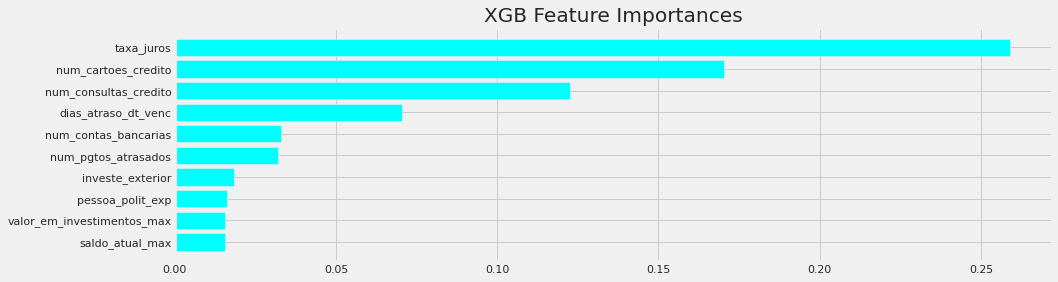

In [46]:
print(f"{Fore.CYAN}{Style.BRIGHT}Average AUC = {sum(aucs) / len(aucs):.5f}\nAverage F1-Score = {sum(f1s) / len(f1s):.5f}{Style.RESET_ALL}")

if type(model_xgb).__name__ == 'XGBClassifier':
    # Show feature importances
    importance_df = pd.DataFrame(np.array(importances).T, index=FEATURES)
    importance_df['mean'] = importance_df.mean(axis=1).abs()
    importance_df['feature'] = FEATURES
    importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(10)
    plt.figure(figsize=(14, 4))
    plt.barh(importance_df.index, importance_df['mean'], color='cyan')
    plt.gca().invert_yaxis()
    plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
    plt.title('XGB Feature Importances')
    plt.show()
# else:
#     importance_df = pd.DataFrame(np.array(importances).T, index=FEATURES)
#     importance_df['mean'] = importance_df.mean(axis=1).abs()
#     importance_df['feature'] = FEATURES
#     importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(15)
#     plt.figure(figsize=(14, 4))
#     plt.barh(importance_df.index, importance_df['mean'], color='cyan')
#     plt.gca().invert_yaxis()
#     plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
#     plt.title('Feature Importances')
#     plt.show()

### 4.3.1 Optuna - XGB

In [268]:
def objective(trial):
    
    train_x, test_x, train_y, test_y = train_test_split(X[FEATURES], y, test_size=0.20,random_state=42)
    param = {
#         'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02, 0.03, 0.05, 0.08]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
#         'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBClassifier(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
#     preds = model.predict(test_x)
    
    scores = cross_val_score(model, X[FEATURES], y,
                              cv=5,
                              scoring='f1_weighted')

    scores_mean = scores.mean()
                  
    print(f'F1 Score Average: {scores_mean}' )
                  
    return scores_mean


study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=30);

trial = study.best_trial

print('Best F1 Score: {}'.format(trial.value))
print('Best hyperparam: {}'.format(trial.params))

[I 2022-10-22 20:03:07,918] A new study created in memory with name: no-name-5896a655-77e3-468c-9f55-48ef2df1162b
[I 2022-10-22 20:03:30,132] Trial 0 finished with value: 0.8667562058406715 and parameters: {'lambda': 0.11077359948806617, 'alpha': 0.06165216314386818, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.008, 'n_estimators': 2766, 'max_depth': 11, 'min_child_weight': 31}. Best is trial 0 with value: 0.8667562058406715.


F1 Score Average: 0.8667562058406715


[I 2022-10-22 20:03:35,221] Trial 1 finished with value: 0.8623304284116303 and parameters: {'lambda': 0.010666535726107708, 'alpha': 0.807992085618941, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.012, 'n_estimators': 878, 'max_depth': 11, 'min_child_weight': 70}. Best is trial 0 with value: 0.8667562058406715.


F1 Score Average: 0.8623304284116303


[I 2022-10-22 20:03:44,251] Trial 2 finished with value: 0.849516132674837 and parameters: {'lambda': 0.0629075534772257, 'alpha': 0.0016845997718819108, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 2945, 'max_depth': 15, 'min_child_weight': 127}. Best is trial 0 with value: 0.8667562058406715.


F1 Score Average: 0.849516132674837


[I 2022-10-22 20:03:53,487] Trial 3 finished with value: 0.8491729927652825 and parameters: {'lambda': 3.214367321125314, 'alpha': 0.0014797044019375656, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.016, 'n_estimators': 2820, 'max_depth': 7, 'min_child_weight': 161}. Best is trial 0 with value: 0.8667562058406715.


F1 Score Average: 0.8491729927652825


[I 2022-10-22 20:03:56,878] Trial 4 finished with value: 0.8317913728405149 and parameters: {'lambda': 1.4961516677578546, 'alpha': 0.019739970163628363, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.016, 'n_estimators': 1142, 'max_depth': 15, 'min_child_weight': 262}. Best is trial 0 with value: 0.8667562058406715.


F1 Score Average: 0.8317913728405149


[I 2022-10-22 20:04:04,978] Trial 5 finished with value: 0.8467108504729699 and parameters: {'lambda': 0.014512982775586538, 'alpha': 0.0014129012792161054, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.012, 'n_estimators': 2701, 'max_depth': 5, 'min_child_weight': 149}. Best is trial 0 with value: 0.8667562058406715.


F1 Score Average: 0.8467108504729699


[I 2022-10-22 20:04:07,737] Trial 6 finished with value: 0.8409545169807909 and parameters: {'lambda': 0.08883114551605924, 'alpha': 0.002039169908665134, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.018, 'n_estimators': 677, 'max_depth': 7, 'min_child_weight': 170}. Best is trial 0 with value: 0.8667562058406715.


F1 Score Average: 0.8409545169807909


[I 2022-10-22 20:04:12,046] Trial 7 finished with value: 0.8588084433312245 and parameters: {'lambda': 0.13432302660171946, 'alpha': 0.002137475011451943, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.05, 'n_estimators': 1096, 'max_depth': 13, 'min_child_weight': 47}. Best is trial 0 with value: 0.8667562058406715.


F1 Score Average: 0.8588084433312245


[I 2022-10-22 20:04:18,239] Trial 8 finished with value: 0.768374211572441 and parameters: {'lambda': 0.04884196622994796, 'alpha': 0.014659406514498912, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.01, 'n_estimators': 2494, 'max_depth': 7, 'min_child_weight': 252}. Best is trial 0 with value: 0.8667562058406715.


F1 Score Average: 0.768374211572441


[I 2022-10-22 20:04:24,831] Trial 9 finished with value: 0.768374211572441 and parameters: {'lambda': 0.08376116712527523, 'alpha': 0.06549230479605397, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.08, 'n_estimators': 2818, 'max_depth': 11, 'min_child_weight': 293}. Best is trial 0 with value: 0.8667562058406715.


F1 Score Average: 0.768374211572441


[I 2022-10-22 20:04:47,916] Trial 10 finished with value: 0.8677244222957535 and parameters: {'lambda': 0.7043256414727058, 'alpha': 6.796620279844995, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.008, 'n_estimators': 1958, 'max_depth': 17, 'min_child_weight': 3}. Best is trial 10 with value: 0.8677244222957535.


F1 Score Average: 0.8677244222957535


[I 2022-10-22 20:05:20,307] Trial 11 finished with value: 0.8663222054332034 and parameters: {'lambda': 0.6722331753408978, 'alpha': 3.2701604071071078, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.008, 'n_estimators': 2037, 'max_depth': 17, 'min_child_weight': 1}. Best is trial 10 with value: 0.8677244222957535.


F1 Score Average: 0.8663222054332034


[I 2022-10-22 20:06:02,221] Trial 12 finished with value: 0.8624393629945866 and parameters: {'lambda': 0.0014711629873093216, 'alpha': 0.35631967706472495, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.008, 'n_estimators': 1925, 'max_depth': 17, 'min_child_weight': 3}. Best is trial 10 with value: 0.8677244222957535.


F1 Score Average: 0.8624393629945866


[I 2022-10-22 20:06:14,284] Trial 13 finished with value: 0.8621246527250012 and parameters: {'lambda': 0.5057473871649111, 'alpha': 7.465053157232862, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.008, 'n_estimators': 2148, 'max_depth': 9, 'min_child_weight': 66}. Best is trial 10 with value: 0.8677244222957535.


F1 Score Average: 0.8621246527250012


[I 2022-10-22 20:06:15,246] Trial 14 finished with value: 0.8277621065218679 and parameters: {'lambda': 9.687785507961296, 'alpha': 0.18807548692011927, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.008, 'n_estimators': 103, 'max_depth': 17, 'min_child_weight': 94}. Best is trial 10 with value: 0.8677244222957535.


F1 Score Average: 0.8277621065218679


[I 2022-10-22 20:06:27,213] Trial 15 finished with value: 0.8656157238813821 and parameters: {'lambda': 0.2998739708132247, 'alpha': 0.05145624444393042, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.03, 'n_estimators': 1492, 'max_depth': 11, 'min_child_weight': 33}. Best is trial 10 with value: 0.8677244222957535.


F1 Score Average: 0.8656157238813821


[I 2022-10-22 20:06:38,720] Trial 16 finished with value: 0.8614753176323411 and parameters: {'lambda': 0.024889141543859742, 'alpha': 1.0267761739907948, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.008, 'n_estimators': 2347, 'max_depth': 5, 'min_child_weight': 108}. Best is trial 10 with value: 0.8677244222957535.


F1 Score Average: 0.8614753176323411


[I 2022-10-22 20:06:47,765] Trial 17 finished with value: 0.8622811924986925 and parameters: {'lambda': 0.002174043784507874, 'alpha': 0.009833972632207713, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.014, 'n_estimators': 1648, 'max_depth': 9, 'min_child_weight': 31}. Best is trial 10 with value: 0.8677244222957535.


F1 Score Average: 0.8622811924986925


[I 2022-10-22 20:06:56,993] Trial 18 finished with value: 0.8638973420060028 and parameters: {'lambda': 0.23870458307249623, 'alpha': 9.768220967620689, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 1703, 'max_depth': 13, 'min_child_weight': 85}. Best is trial 10 with value: 0.8677244222957535.


F1 Score Average: 0.8638973420060028


[I 2022-10-22 20:07:04,374] Trial 19 finished with value: 0.834257516082071 and parameters: {'lambda': 1.2256195397197016, 'alpha': 1.826002368427969, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.08, 'n_estimators': 2351, 'max_depth': 17, 'min_child_weight': 198}. Best is trial 10 with value: 0.8677244222957535.


F1 Score Average: 0.834257516082071


[I 2022-10-22 20:07:14,912] Trial 20 finished with value: 0.8626146626847288 and parameters: {'lambda': 0.006156042380144676, 'alpha': 0.24553257735697845, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.03, 'n_estimators': 1431, 'max_depth': 11, 'min_child_weight': 26}. Best is trial 10 with value: 0.8677244222957535.


F1 Score Average: 0.8626146626847288


[I 2022-10-22 20:07:41,856] Trial 21 finished with value: 0.8685818878787952 and parameters: {'lambda': 0.7103261259878902, 'alpha': 3.818812772685153, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.008, 'n_estimators': 2085, 'max_depth': 17, 'min_child_weight': 7}. Best is trial 21 with value: 0.8685818878787952.


F1 Score Average: 0.8685818878787952


[I 2022-10-22 20:07:54,016] Trial 22 finished with value: 0.8628578939361613 and parameters: {'lambda': 3.021134647067766, 'alpha': 3.142421174745128, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.008, 'n_estimators': 1910, 'max_depth': 17, 'min_child_weight': 55}. Best is trial 21 with value: 0.8685818878787952.


F1 Score Average: 0.8628578939361613


[I 2022-10-22 20:08:30,601] Trial 23 finished with value: 0.8658686376037498 and parameters: {'lambda': 0.22415492884264313, 'alpha': 0.47601375444642835, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.008, 'n_estimators': 2611, 'max_depth': 17, 'min_child_weight': 6}. Best is trial 21 with value: 0.8685818878787952.


F1 Score Average: 0.8658686376037498


[I 2022-10-22 20:08:45,343] Trial 24 finished with value: 0.8669380174147602 and parameters: {'lambda': 0.7630412661951048, 'alpha': 4.622950390477795, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 2247, 'max_depth': 17, 'min_child_weight': 28}. Best is trial 21 with value: 0.8685818878787952.


F1 Score Average: 0.8669380174147602


[I 2022-10-22 20:09:01,009] Trial 25 finished with value: 0.8663199735545092 and parameters: {'lambda': 0.9075628568746578, 'alpha': 4.4850119545398295, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 2224, 'max_depth': 17, 'min_child_weight': 23}. Best is trial 21 with value: 0.8685818878787952.


F1 Score Average: 0.8663199735545092


[I 2022-10-22 20:09:09,414] Trial 26 finished with value: 0.8598826987440382 and parameters: {'lambda': 2.7884002364348053, 'alpha': 1.230722197576191, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 1855, 'max_depth': 17, 'min_child_weight': 73}. Best is trial 21 with value: 0.8685818878787952.


F1 Score Average: 0.8598826987440382


[I 2022-10-22 20:09:21,215] Trial 27 finished with value: 0.8574457465808717 and parameters: {'lambda': 6.573564290826953, 'alpha': 2.22737767531831, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.05, 'n_estimators': 2433, 'max_depth': 17, 'min_child_weight': 49}. Best is trial 21 with value: 0.8685818878787952.


F1 Score Average: 0.8574457465808717


[I 2022-10-22 20:09:27,094] Trial 28 finished with value: 0.8514014869297108 and parameters: {'lambda': 0.4092976752503542, 'alpha': 7.849613048735641, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 1334, 'max_depth': 17, 'min_child_weight': 114}. Best is trial 21 with value: 0.8685818878787952.


F1 Score Average: 0.8514014869297108


[I 2022-10-22 20:09:45,055] Trial 29 finished with value: 0.8656694532551846 and parameters: {'lambda': 2.1815945085319486, 'alpha': 4.8592174595321636, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.014, 'n_estimators': 2155, 'max_depth': 17, 'min_child_weight': 20}. Best is trial 21 with value: 0.8685818878787952.


F1 Score Average: 0.8656694532551846
Best F1 Score: 0.8685818878787952
Best hyperparam: {'lambda': 0.7103261259878902, 'alpha': 3.818812772685153, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.008, 'n_estimators': 2085, 'max_depth': 17, 'min_child_weight': 7}


In [271]:
"""F1 Score Average: 0.8656694532551846
Best F1 Score: 0.8685818878787952
Best hyperparam: {'lambda': 0.7103261259878902, 
                  'alpha': 3.818812772685153, 
                  'colsample_bytree': 0.8, 
                  'subsample': 0.6, 
                   'learning_rate': 0.008, 
                   'n_estimators': 2085, 
                   'max_depth': 17, 
                   'min_child_weight': 7}"""

"F1 Score Average: 0.8656694532551846\nBest F1 Score: 0.8685818878787952\nBest hyperparam: {'lambda': 0.7103261259878902, 'alpha': 3.818812772685153, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.008, 'n_estimators': 2085, 'max_depth': 17, 'min_child_weight': 7}"

## 4.4 LGBM

In [47]:
%%time

f1s = []
aucs = []
preds_test = []
importances = []
oof_pred = []; oof_tar = []; oof_names = []; oof_folds = [] 
kf = StratifiedKFold(n_splits=CFG.FOLDS, shuffle=True, random_state=CFG.seed)

for fold, (tr_idx, val_idx) in enumerate(kf.split(X[FEATURES], X[TARGET])):
    print('Fold:', fold)
    
    # split train/val
    X_tr = X.loc[tr_idx, FEATURES]
    y_tr = X.loc[tr_idx, TARGET]
    X_va = X.loc[val_idx, FEATURES]
    y_va = X.loc[val_idx, TARGET]
    

    # MODEL
    model_lgb = lgbm.LGBMClassifier(
                reg_lambda= 1.6626804101540482, 
                  alpha= 0.29793371309642636, 
                  colsample_bytree= 0.9, 
                  subsample= 0.7, 
                  learning_rate= 0.15, 
                  n_estimators= 200, 
                  max_depth= 17,
                  num_leaves=100,
                  min_child_weight= 49,
                n_jobs=-1
    )

    
    model_lgb.fit(X_tr, y_tr)
                                    
    # Validate model
    va_preds = model_lgb.predict_proba(X_va)[:, 1]
    vaf1_preds = model_lgb.predict(X_va)
    score    = roc_auc_score(y_va, va_preds)
    f1       = f1_score(y_va, vaf1_preds, average='weighted')
    print(f"AUC = {score:.5f} F1-Score: {f1:.5f}") # , C = {model.get_params['C']}, penalty = {model.get_params['penalty']}
    aucs.append(score)
    f1s.append(f1)
    
    # Test set predictions
#     preds_test.append(model.predict_proba(test[FEATURES])[:, 1])
    preds_test.append(model_lgb.predict(test_aux[FEATURES]))
    df_sub[f'fold_{fold}'] = preds_test[fold]
    
    
    # Feature Importances
    importances.append(model_lgb.feature_importances_)
    
    
    ### free memory
#     del X_tr, y_tr
#     del X_va, y_va
    gc.collect()

    
    
print(f'\nAverage AUC = {sum(aucs) / len(aucs):.5f}')
print(f'Average F1-Score = {sum(f1s) / len(f1s):.5f}' )
print('')
preds_lgb = sum(preds_test)/len(preds_test)

Fold: 0
AUC = 0.90338 F1-Score: 0.85908
Fold: 1
AUC = 0.93540 F1-Score: 0.88193
Fold: 2
AUC = 0.92510 F1-Score: 0.88133
Fold: 3
AUC = 0.92640 F1-Score: 0.87736
Fold: 4
AUC = 0.92021 F1-Score: 0.86324

Average AUC = 0.92210
Average F1-Score = 0.87259

CPU times: user 5.87 s, sys: 29.6 ms, total: 5.9 s
Wall time: 987 ms


In [48]:
fpr, tpr, thresholds = roc_curve(y_va, va_preds)

In [49]:
np.mean(thresholds)

0.4272457846856145

### 4.4.1 Optuna - LGBM

In [291]:
# def objective(trial):
#     params = {
#         'metric':'f1',
# #         'tree_method':'gpu_hist',  
#         'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
#         'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
#         'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5,0.6,0.7,0.8,0.9,1.0]),
#         'subsample': trial.suggest_categorical('subsample', [0.6,0.7,0.8,1.0]),
#         'learning_rate': trial.suggest_categorical('learning_rate', [0.15,0.02,0.025,0.03]),
#         'n_estimators': trial.suggest_categorical("n_estimators", [150, 200, 300,1000, 1500]),
#         'max_depth': trial.suggest_categorical('max_depth', [4,5,7,9,11,13,15,17]),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),

#     }
    
#     model =  lgbm.LGBMClassifier(**params)
#     scores = cross_val_score(model, X[FEATURES], y,
#                               cv=5,
#                               scoring='f1_weighted')

#     scores_mean = scores.mean()
                  
#     print(f'F1 Score Average: {scores_mean}' )
                  
#     return scores_mean

# study = optuna.create_study(direction='maximize')
# study.optimize(objective,n_trials=30);

# trial = study.best_trial

# print('Best F1 Score: {}'.format(trial.value))
# print('Best hyperparam: {}'.format(trial.params))

In [ ]:
"""
Best F1 Score: 0.8696550511688275
Best hyperparam: {'lambda': 1.6626804101540482, 
                  'alpha': 0.29793371309642636, 
                  'colsample_bytree': 0.9, 
                  'subsample': 0.7, 
                  'learning_rate': 0.15, 
                  'n_estimators': 150, 
                  'max_depth': 17, 
                  'min_child_weight': 49}"""

## 4.5 Feature Importances

Average AUC = 0.92210
Average F1-Score = 0.87259


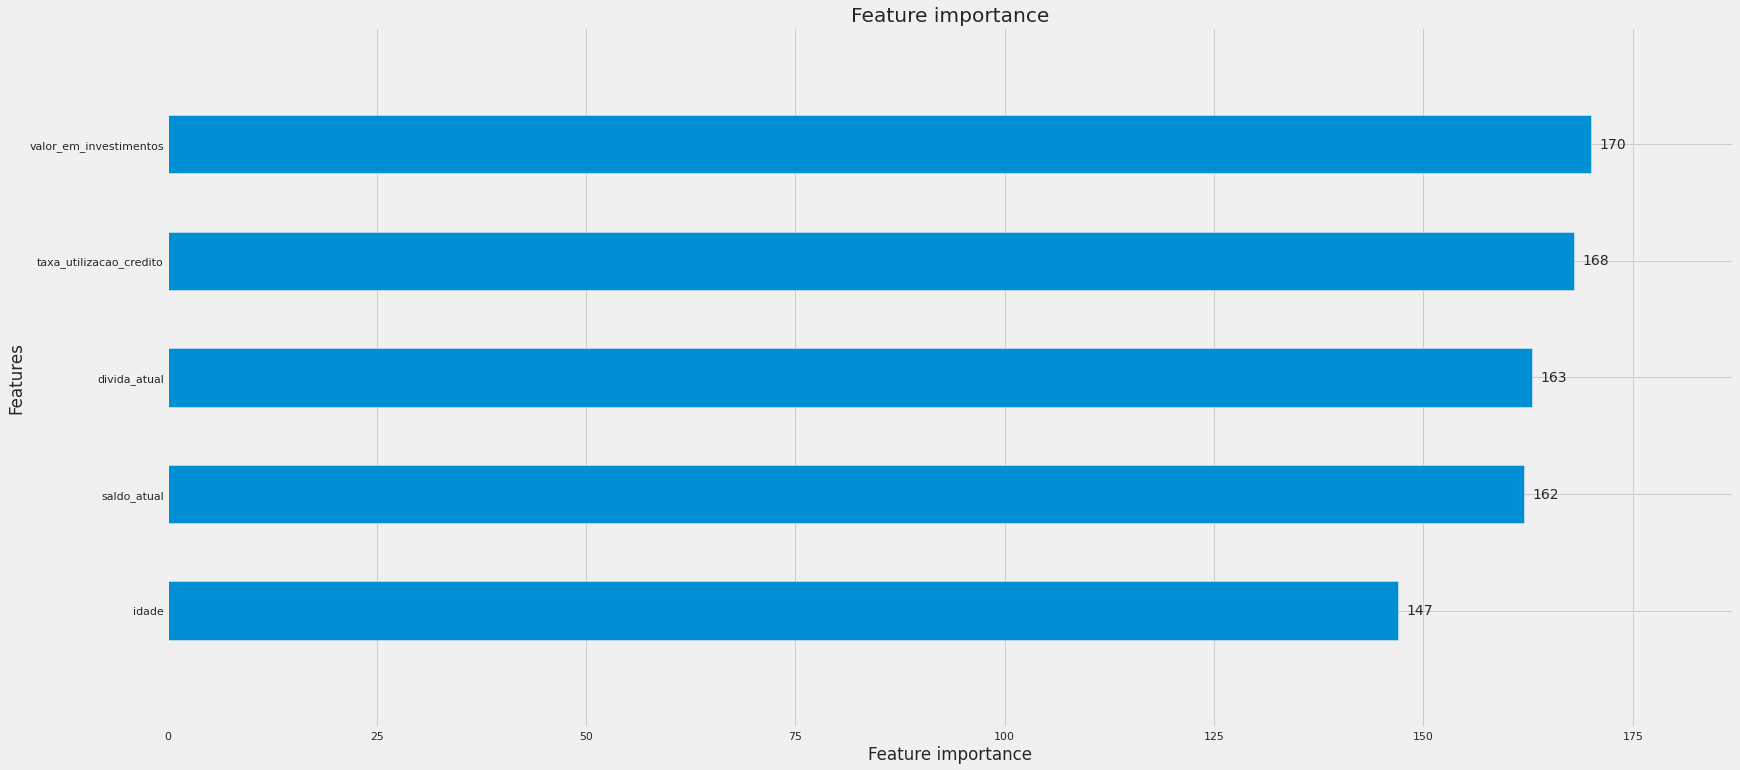

In [50]:
print(f"{Fore.CYAN}{Style.BRIGHT}Average AUC = {sum(aucs) / len(aucs):.5f}\nAverage F1-Score = {sum(f1s) / len(f1s):.5f}{Style.RESET_ALL}")

if type(model_lgb).__name__ == 'LGBMClassifier':
    lgbm.plot_importance(model_lgb, max_num_features = 5, height=.5)
else:
    importance_df = pd.DataFrame(np.array(importances).T, index=FEATURES)
    importance_df['mean'] = importance_df.mean(axis=1).abs()
    importance_df['feature'] = FEATURES
    importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(5)
    plt.figure(figsize=(14, 4))
    plt.barh(importance_df.index, importance_df['mean'], color='cyan')
    plt.gca().invert_yaxis()
    plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
    plt.title('LGBM Feature Importances')
    plt.show()

In [ ]:
mi_scores = mutual_info_classif(X[FEATURES], y)
mi_scores_classif = make_mi_scores(mi_scores, X[FEATURES], y)

plt.figure(dpi=100, figsize=(12, 8))
columns = plot_mi_scores(mi_scores_classif[mi_scores_classif > 1e-3], X)

# 5.0 Non-Nested CV

Tried a different approach from KFold Cross-Validation and it seems to have worked out :)

In [51]:
# INSERIR MANUALMENTE!
MODEL_INFO = 'XGB_LGBM_ensemble_02_featAgg'

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X[FEATURES], y, test_size=.2)

In [53]:
xgb_model = xgb.XGBClassifier(n_estimators=300)
xgb_model.fit(X_train[FEATURES], y_train,
            eval_set=[(X_train[FEATURES],y_train)\
                      ,(X_val[FEATURES], y_val)],
            early_stopping_rounds=25,
           verbose=False)
predictions = xgb_model.predict(X_val[FEATURES])

X_val['predictions'] = predictions
f1_score(y_val,X_val.predictions, average='weighted')

0.8626899772845338

In [54]:
lgb_model = lgbm.LGBMClassifier(n_estimators=1000)
lgb_model.fit(X_train[FEATURES], y_train,
        eval_set=[(X_train[FEATURES],y_train)\
                  ,(X_val[FEATURES], y_val)],
        early_stopping_rounds=25,verbose=False)

X_val['predictions'] = lgb_model.predict(X_val[FEATURES])
f1_score(y_val,X_val.predictions, average='weighted')

0.8631630455413156

In [59]:
predictions1 = lgb_model.predict(test_aux[FEATURES])
predictions2 = xgb_model.predict(test_aux[FEATURES])

predictions = (predictions1*0.49)+(predictions2*(0.51))

# 6.0 Submission

In [61]:
df_sub['limite_adicional'] = predictions

In [62]:
df_sub['limite_adicional'] = df_sub['limite_adicional'].apply(lambda x: 0 if x < 0.5 else 1)

In [63]:
df_sub['limite_adicional'] = df_sub['limite_adicional'].replace([0, 1], ['Negar', 'Conceder'])

In [64]:
df_sub[['id_cliente', 'limite_adicional']].head()

,id_cliente,limite_adicional
0,2,Conceder
1,5,Negar
2,6,Negar
3,8,Negar
4,10,Conceder


In [61]:
df_sub[['id_cliente', 'limite_adicional']].to_csv(f'subs/sub_{MODEL_INFO}.csv', index=False)

In [65]:
df_sub[TARGET].value_counts()

Negar       2637
Conceder     363
Name: limite_adicional, dtype: int64